# Sistemas Híbridos

Atividade referente ao assunto Sistemas Híbridos. 

O objetivo dessa atividade foi implementar um Sistema Híbirdo, conforme Zhang (2003), para realizar previsão do logaritmo da taxa de mortalidade da idade de 40 anos da população francesa. 

A metodologia consiste em realizar a modelagem da série $Z_t$ a partir da equação $Z_t=L_t + N_t$.  
Para tanto, utilizou-se um Arima(p,d,q) para modelar $L_t$, enquanto que a estrutura não linear, $N_t$, foi modelada pelas Redes Neurais Artificiais, especificamente por uma Multilayer Perceptron (MLP).

Metodologia:
1. Treinar um ARIMA
2. Calcular o erro do ARIMA nos dados de treinamento
3. Treinar uma MLP no erro do ARIMA
4. Realizar a Previsão do ARIMA: h = 20
5. Realizar a Previsão por MLP com 20 saídas



O trabalho está dividido em: 
* Funções implementadas
* Carregamento das bibliotecas
* Importação dos dados
* Análise gráfica e estatística da série temporal
* ARIMA
* MLP
* Aplicação do Sistema Híbrido - ARIMA + MLP

#### Funções implementadas

In [1]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [2]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [3]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
            
    return janelas_np

In [4]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()

In [5]:
def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [6]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [7]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

### Carregando biblioteca

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
from pmdarima import auto_arima
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
import os
os.chdir("/Users/filipeduarte/Documents/Mortality_data")
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/filipeduarte/Documents/Mortality_data'

### Importação dos dados

In [10]:
# importing data
lnmx_series = pd.read_csv('lnmx_series.csv', sep = ',', index_col = 0)
lnmx_series.head()

,0,1,2,5,10,12,15,18,20,22,25,28,30,40,50,60,70,80,90,100
Year,,,,,,,,,,,,,,,,,,,,
1816,-1.583074,-3.064332,-3.377842,-4.287954,-5.091791,-5.344152,-5.227673,-4.898736,-4.720806,-4.601178,-4.580380,-4.682375,-4.678817,-4.431805,-4.019219,-3.380601,-2.652838,-1.813196,-1.471469,-1.039535
1817,-1.608114,-2.917439,-3.250650,-4.178923,-5.048181,-5.240992,-5.115163,-4.873834,-4.696518,-4.641212,-4.641834,-4.720357,-4.697505,-4.393209,-3.957125,-3.337293,-2.654088,-1.835461,-1.475817,-0.584203
1818,-1.601852,-2.794409,-3.181171,-4.111145,-4.999844,-5.203553,-5.079503,-4.841906,-4.676129,-4.603172,-4.639865,-4.684863,-4.645680,-4.389253,-3.987016,-3.382189,-2.689837,-1.894510,-1.497753,-0.489103
1819,-1.532375,-2.709036,-3.081486,-4.009581,-4.854401,-5.175923,-5.117664,-4.838112,-4.671951,-4.554287,-4.626700,-4.658044,-4.622723,-4.386035,-3.974377,-3.403791,-2.718570,-1.903165,-1.486446,-0.719076
1820,-1.622807,-2.861656,-3.217926,-4.133169,-4.927030,-5.293131,-5.237787,-4.909931,-4.752858,-4.633775,-4.728242,-4.756226,-4.692036,-4.425435,-3.968329,-3.370368,-2.669195,-1.794227,-1.418202,-0.639684


In [11]:
import os
os.chdir("/Users/filipeduarte/Desktop/TimeSeriesCin-master")
os.getcwd()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/filipeduarte/Desktop/TimeSeriesCin-master'

#### Análise gráfica e estatística

In [12]:
idades = lnmx_series.columns
idades

Index(['0', '1', '2', '5', '10', '12', '15', '18', '20', '22', '25', '28',
       '30', '40', '50', '60', '70', '80', '90', '100'],
      dtype='object')

In [13]:
# Começar com a idade 40 anos
lnmx = lnmx_series['40']

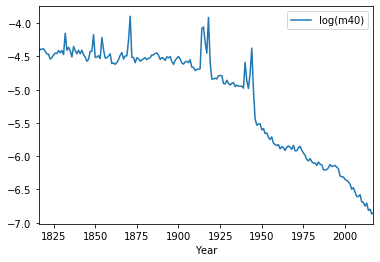

In [14]:
# gráfico 
lnmx.plot(label='log(m40)')
plt.legend()
plt.show()

Verifica-se um comportamento muito distinto a partir do ano de 1950. 

Sendo assim, optou-se por utilizar a série a partir dessa data até 2017.

In [15]:
# Antes de aplicar o Arima, vamos dividir os dados em treinamento e teste. 
# Como vou aplicar uma janela com 2 lags passados e 19 anos para previsão, vamos ficar com os anos 1816:1990 para treinamento
# e 1991:2010 para teste
treino = lnmx.loc[:1991]
teste = lnmx.loc[1991:2010]

* Treinamento: 1816-1990
* Teste: 1991-2010

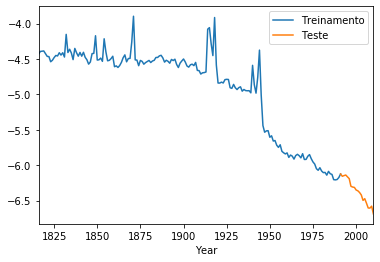

In [16]:
# Visualizar o gráfico 
treino.plot(label = 'Treinamento')
teste.plot(label='Teste')
plt.legend()
plt.show()

In [17]:
# calcular as estatísticas
treino.describe()

count    176.000000
mean      -4.903109
std        0.624666
min       -6.207136
25%       -5.512936
50%       -4.579212
75%       -4.481538
max       -3.895854
Name: 40, dtype: float64

In [18]:
teste.describe()

count    20.000000
mean     -6.366835
std       0.178995
min      -6.687817
25%      -6.506776
50%      -6.355612
75%      -6.183168
max      -6.123854
Name: 40, dtype: float64

In [19]:
# Analisar a estacionariedade da série de treinamento
result = adfuller(treino)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.086739
p-value: 0.965144
Critical Values:
	1%: -3.469
	5%: -2.878
	10%: -2.576


Resultados indicam que a série é não estacionária. Dessa maneira, temos que realizar a diferenciação pelo modelo Arima.
Próximo passo será analisar o autocorrelograma/parcial da série de treinamento diferenciada.

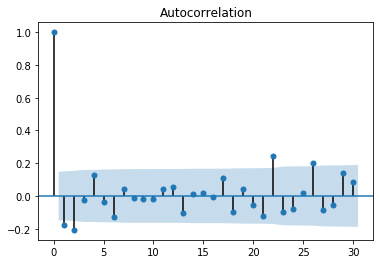

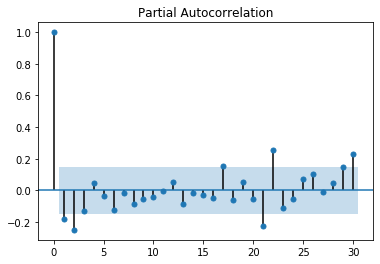

In [20]:
plot_acf(treino.diff().dropna(), lags=30)
plot_pacf(treino.diff().dropna(), lags = 30)
plt.show()

Autocorrelação de ordem 2

### ARIMA

Utilizou-se o auto_arima da biblioteca pyramid.arima para modelar a série de treinamento. 

O auto_arima busca o modelo com o menor AIC, a partir de uma busca iniciando com os parâmetros pelos modelos mais parcimoniosos.

In [21]:
stepwise_model = auto_arima(treino, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=12,
                           start_P=0, seasonal=False,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Fit ARIMA: order=(1, 1, 1); AIC=-189.900, BIC=-177.241, Fit time=0.103 seconds
Fit ARIMA: order=(0, 1, 0); AIC=-176.312, BIC=-169.983, Fit time=0.004 seconds
Fit ARIMA: order=(1, 1, 0); AIC=-179.948, BIC=-170.453, Fit time=0.014 seconds
Fit ARIMA: order=(0, 1, 1); AIC=-185.063, BIC=-175.568, Fit time=0.018 seconds
Fit ARIMA: order=(2, 1, 1); AIC=-189.131, BIC=-173.307, Fit time=0.072 seconds
Fit ARIMA: order=(1, 1, 2); AIC=-189.058, BIC=-173.234, Fit time=0.085 seconds
Fit ARIMA: order=(2, 1, 2); AIC=-187.132, BIC=-168.144, Fit time=0.115 seconds
Total fit time: 0.413 seconds


In [22]:
# melhor AIC - modelo (1,1,1)
stepwise_model.aic()

-189.90011962478815

O modelo selecionado será o ARIMA(p=1,q=1,d=1), ou seja, diferenciado em 1ª ordem e ARMA(1). 

In [23]:
# treinamento do arima(1,1,1)
stepwise_model.fit(treino)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(1, 1, 1),
      out_of_sample_size=0, scoring='mse', scoring_args={}, seasonal_order=None,
      solver='lbfgs', start_params=None, suppress_warnings=True,
      transparams=True, trend=None, with_intercept=True)

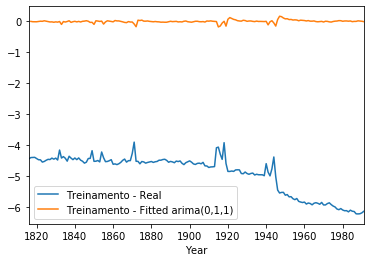

In [24]:
# extração do fit e plotando o gráfico
arima_fit_treino = stepwise_model.predict_in_sample()
#arima_fit_treino = incrementar_serie(serie_diff=arima_fit_treino, serie_real=treino)
arima_fit_treino = pd.Series(arima_fit_treino, index = treino[1:].index)
treino.plot(label='Treinamento - Real')
arima_fit_treino.plot(label='Treinamento - Fitted arima(0,1,1)')
plt.legend()
plt.show()

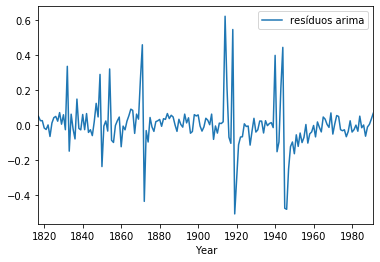

In [25]:
# extração dos resíduos e plotando o gráfico
resid_arima = stepwise_model.resid()
resid_arima = pd.Series(resid_arima, index = treino[1:].index)
resid_arima.plot(label='resíduos arima')
plt.legend()
plt.show()

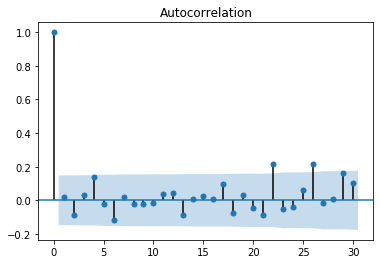

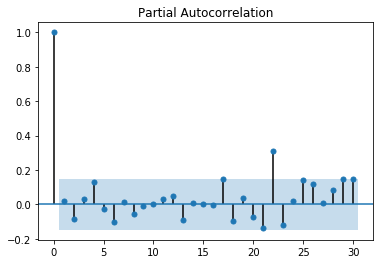

In [26]:
# Análise do autocorrelograma dos resíduos
plot_acf(resid_arima, lags=30)
plot_pacf(resid_arima, lags=30)
plt.show()

In [27]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [28]:
# Criar as janelas com 20 saídas para y e 20 lags
values = list(resid_arima)
data = series_to_supervised(values, 30, 20)
data.head()

,var1(t-30),var1(t-29),var1(t-28),var1(t-27),var1(t-26),var1(t-25),var1(t-24),var1(t-23),var1(t-22),var1(t-21),...,var1(t+10),var1(t+11),var1(t+12),var1(t+13),var1(t+14),var1(t+15),var1(t+16),var1(t+17),var1(t+18),var1(t+19)
30,0.048687,0.024228,0.024159,-0.017721,-0.026082,-0.000177,-0.065880,0.010538,0.041385,0.048351,...,-0.003259,0.023665,0.044802,-0.124485,-0.006718,-0.027982,0.021494,0.052517,0.089828,0.083003
31,0.024228,0.024159,-0.017721,-0.026082,-0.000177,-0.065880,0.010538,0.041385,0.048351,0.021215,...,0.023665,0.044802,-0.124485,-0.006718,-0.027982,0.021494,0.052517,0.089828,0.083003,-0.048425
32,0.024159,-0.017721,-0.026082,-0.000177,-0.065880,0.010538,0.041385,0.048351,0.021215,0.070146,...,0.044802,-0.124485,-0.006718,-0.027982,0.021494,0.052517,0.089828,0.083003,-0.048425,0.061612
33,-0.017721,-0.026082,-0.000177,-0.065880,0.010538,0.041385,0.048351,0.021215,0.070146,0.004116,...,-0.124485,-0.006718,-0.027982,0.021494,0.052517,0.089828,0.083003,-0.048425,0.061612,0.032931
34,-0.026082,-0.000177,-0.065880,0.010538,0.041385,0.048351,0.021215,0.070146,0.004116,0.057911,...,-0.006718,-0.027982,0.021494,0.052517,0.089828,0.083003,-0.048425,0.061612,0.032931,0.261318


### MLP

In [29]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    
    
    neuronios =  [1, 2, 3, 5, 10]    #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['tanh', 'relu']   #['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs', 'sgd', 'adam']#, ['lbfgs','sgd', 'adam']
    max_iteracoes = [10000] #[100, 1000, 10000]
    learning_rate = ['adaptive']  #['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                rmse = np.sqrt(MSE(y_val, predict_validation))

                                if rmse < best_result:
                                    best_result = rmse
                                    print('Melhor RMSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

In [30]:
# Transformando em array
X, y = np.array(data.iloc[:,:30]), np.array(data.iloc[:,30:])

In [31]:
# Criando os conjuntos de treinamento, validação e teste
def divisao_dados_temporais(X,y, perc_treino, perc_val = 0):
    tam_treino = int(perc_treino * len(y))
    
    if perc_val > 0:        
        tam_val = int(len(y)*perc_val)
              
        X_treino = X[0:tam_treino,:]
        y_treino = y[0:tam_treino,:]
        
        print("Particao de Treinamento:", 0, tam_treino)
        
        X_val = X[tam_treino:tam_treino+tam_val,:]
        y_val = y[tam_treino:tam_treino+tam_val,:]
        
        print("Particao de Validacao:",tam_treino,tam_treino+tam_val)
        
        X_teste = X[(tam_treino+tam_val):-1,:]
        y_teste = y[(tam_treino+tam_val):-1,:]
        
        print("Particao de Teste:", tam_treino+tam_val, len(y))
        
        return X_treino, y_treino, X_teste, y_teste, X_val, y_val
        
    else:
        
        X_treino = X[0:tam_treino,:]
        y_treino = y[0:tam_treino,:]

        X_teste = X[tam_treino:-1,:]
        y_teste = y[tam_treino:-1,:]

        return X_treino, y_treino, X_teste, y_teste 

In [32]:
X_treino, y_treino, X_val, y_val, X_teste, y_teste = divisao_dados_temporais(X, y, perc_treino = 0.6, perc_val = 0.2)

Particao de Treinamento: 0 75
Particao de Validacao: 75 100
Particao de Teste: 100 126


In [33]:
# treinar MLP
mlp_model, lag_sel = treinar_mlp(X_treino, y_treino, X_val, y_val, num_exec = 5)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor RMSE: 0.0579493920240192
Melhor RMSE: 0.05749926443164348
Melhor RMSE: 0.05594903204146339
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 17 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 18 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags

QTD de Lags: 19 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 20 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 21 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 22 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 23 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 24 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 25 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 26 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 27 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 28 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 29 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 3 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 4 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 2 Func. Act tanh
QTD de Lags: 9 Qtd de Neuronios 2 Func. Act tanh
QTD de La

QTD de Lags: 9 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 20 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 21 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 22 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 23 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 24 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 25 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 26 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 27 Qtd de Neuronios 2 Func. Act relu
QTD de Lags: 28 Qtd de Neuronios 2 Func. Act relu
Q

QTD de Lags: 29 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 3 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 3 Func. Act relu
QTD de La

QTD de Lags: 20 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 21 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 22 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 23 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 24 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 25 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 26 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 27 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 28 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 29 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 1 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 3 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 4 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 5 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 6 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 7 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 8 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 9 Qtd de Neuronios 5 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 5 Func. Act relu
QTD de La

QTD de Lags: 9 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 10 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 11 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 12 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 13 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 14 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 15 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 16 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 17 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 18 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 19 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 20 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 21 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 22 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 23 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 24 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 25 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 26 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 27 Qtd de Neuronios 10 Func. Act relu
QTD de Lags: 28 Qtd de Neuronios

In [56]:
mlp_model

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=2, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [57]:
lag_sel

2

In [60]:
# teste da mlp
predict_test = mlp_model.predict(X_teste[:, -lag_sel:])

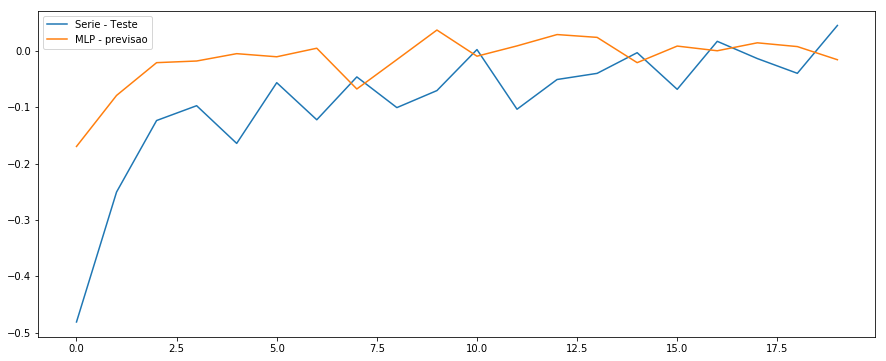

In [61]:
plt.plot(y_teste[-1], label = 'Serie - Teste')
plt.plot(predict_test[-1], label = 'MLP - previsao')
plt.legend(loc='best')
plt.show()

### Aplicação do Sistema Híbrido - ARIMA + MLP

In [62]:
# Realizando as previsões
previsao_mlp = mlp_model.predict(X[:,-lag_sel:])[-1,:]

In [63]:
# Transformando em Série temporal 
previsao_mlp = pd.Series(previsao_mlp, index = teste.index)

In [64]:
# Prevendo com o Arima
arima_teste = stepwise_model.predict(n_periods=20)
arima_teste = pd.Series(arima_teste, index = teste.index)

In [65]:
# Criando o sistema híbrido z = arima + mlp
z = arima_teste+previsao_mlp

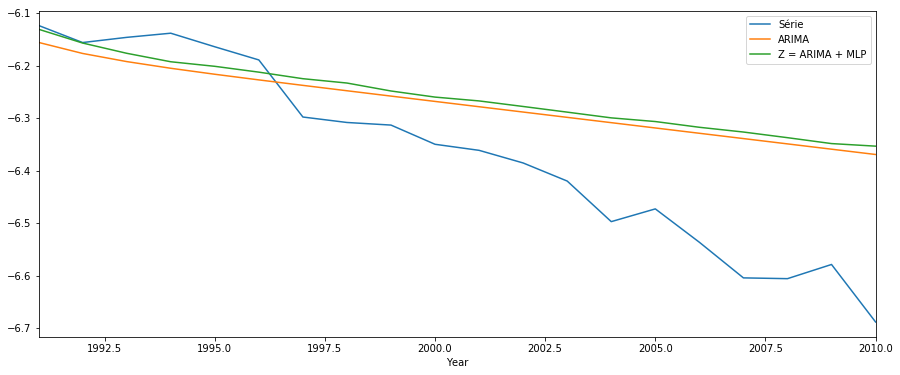

In [66]:
# plotando
teste.plot(label = 'Série')
arima_teste.plot(label = 'ARIMA')
z.plot(label = 'Z = ARIMA + MLP')
plt.legend()
plt.show()

In [67]:
print('RMSE - ARIMA = ',np.sqrt(MSE(teste, arima_teste)))
print('RMSE - Z     = ', np.sqrt(MSE(teste, z)))

RMSE - ARIMA =  0.14961261733589695
RMSE - Z     =  0.1572496515779083


### Conclusão

O modelo ARIMA apresentou um RMSE, para os dados de teste, no valor aproximado de 0.1496. Contudo, quando implementado o sistema híbrido a partir da soma do modelo ARIMA com o modelo MLP, o RMSE aumentou para o valor aproximado de 0.1572. 

Sendo assim, o Sistem Híbrido não apresentou melhores previsões do que o ARIMA. Duas possíveis justificativas podem explicar esse fato:

* O erro de treinamento do ARIMA, que serviu para treinar o modelo MLP, seria uma série não autocorrelacionada.
* O Tamanho da janela de previsão ser de longo prazo.

Vale a pena investigar se outro modelo de machine learning, por exemplo um SVR, conseguiria mapear de forma mais adequada o erro gerado pelo modelo arima. Ademais, seria interessante implementar outra combinação de sistema híbrido, por meio de técnicas como processos gaussianos etc.